In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
import matplotlib.ticker as ticker
from aplpy import FITSFigure  
from numpy import unravel_index

In [43]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'

hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul5 = fits.open(FITS5)


MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapHer250 = hdul5[0]
MapPolSNR = MapDebPol.copy()


BlankedMapPol = MapDebPol.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapHer250 = MapHer250.copy()


######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)

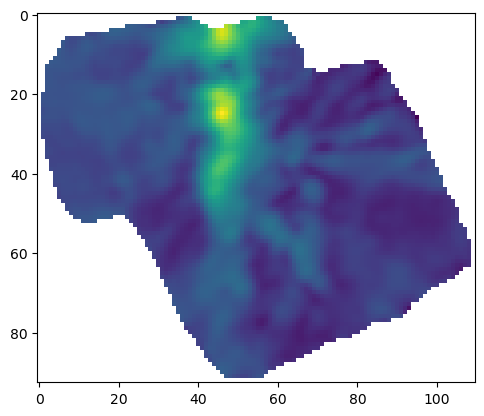

In [44]:
TestData = np.log(MapStokesI.data)
plt.figure()
plt.imshow(TestData)
plt.show()

In [45]:
maxPoint = np.nanmax(TestData)
minPoint = np.nanmin(TestData)
position = np.where(TestData == np.nanmax(TestData))

print(maxPoint)
print(minPoint)
print(TestData[position][0])


5.833313671191778
-2.279248231509839
5.833313671191778


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian

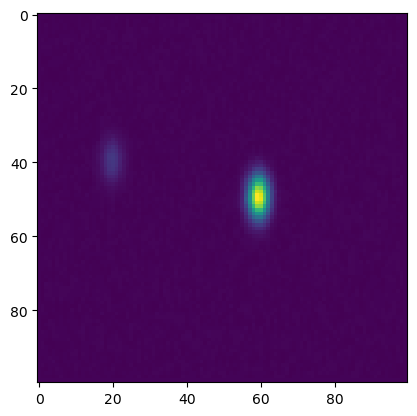

In [47]:
npoints = 10000
np.random.seed(2021)
x = np.random.rand(npoints)*10 - 4
y = np.random.rand(npoints)*5 - 3
z = gaussian2d(x, y, amplitude=30, centerx=2, centery=-.5, sigmax=.2, sigmay=.2)
z += 2*(np.random.rand(*z.shape)-.5)
z += gaussian2d(x, y, amplitude=5, centerx=-2, centery=-1, sigmax=.2, sigmay=.2)
error = np.sqrt(z+1)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                   np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear', fill_value=0)

plt.figure()
plt.imshow(Z)
plt.show()


# X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
#                    np.linspace(y.min(), y.max(), 100))
# Z = griddata((x, y), z, (X, Y), method='linear', fill_value=0)



# fig, ax = plt.subplots()
# art = ax.pcolor(X, Y, Z, shading='auto')
# plt.colorbar(art, ax=ax, label='z')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# plt.show()

In [48]:
model = lmfit.Model(gaussian2d, independent_vars=['x', 'y'])
params = model.make_params(amplitude=30, centerx=x[np.argmax(z)],
                           centery=y[np.argmax(z)],sigmax = 0.3,sigmay = 0.3)
# params['sigmax'].set(value=0.2, min=0)
# params['sigmay'].set(value=0.1, min=0)

result = model.fit(z, x=x, y=y, params=params, weights=1/error)
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 10000
    # variables        = 5
    chi-square         = 29421.7316
    reduced chi-square = 2.94364499
    Akaike info crit   = 10801.4848
    Bayesian info crit = 10837.5365
    R-squared          = 0.92082099
[[Variables]]
    amplitude:  29.7742774 +/- 0.68290490 (2.29%) (init = 30)
    centerx:    1.99928849 +/- 0.00466592 (0.23%) (init = 1.991439)
    centery:   -0.49880790 +/- 0.00485990 (0.97%) (init = -0.4880023)
    sigmax:     0.19736503 +/- 0.00366447 (1.86%) (init = 0.3)
    sigmay:     0.19777856 +/- 0.00369659 (1.87%) (init = 0.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) = 0.116


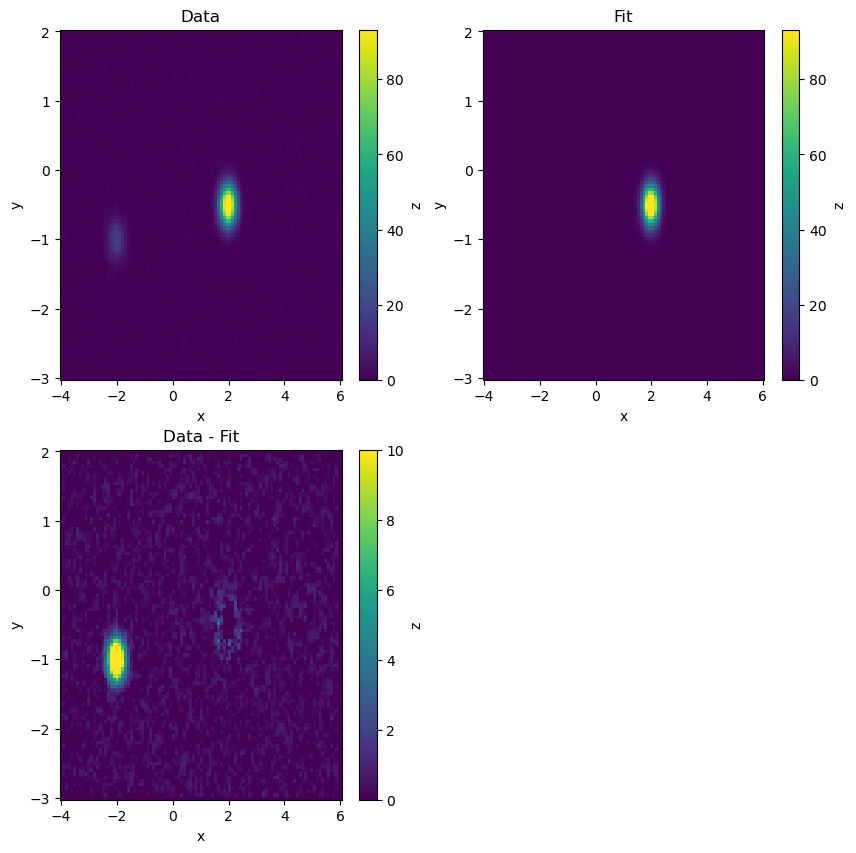

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

vmax = np.nanpercentile(Z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, fit, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

ax = axs[1, 0]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, Z-fit, vmin=0, vmax=10, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
axs[1, 1].remove()
plt.show()

(200, 200)


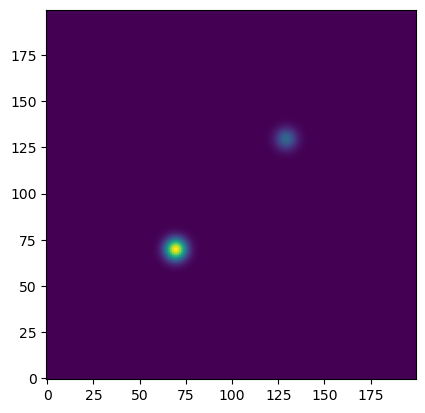

In [50]:
def gauss2d(x,y,amp,centerx,centery,sigmax,sigmay):
    return amp*np.exp(-((x - centerx)**2. / (2. * sigmax**2.) + (y - centery)**2. / (2.*sigmay**2.)))

x = np.linspace(-10,10,200)
y = np.linspace(-10,10,200)

y_grid,x_grid = np.meshgrid(x,y,sparse=False, indexing='ij')
print(y_grid.shape)

z = gauss2d(x_grid,y_grid,30,-3,-3,0.4,0.4)
z += gauss2d(x_grid,y_grid,10,3,3,0.4,0.4)
error = np.sqrt(z + 1)
plt.figure()
plt.imshow(z,origin = 'lower')
plt.show()
 

In [51]:
i,j = np.unravel_index(z.argmax(), z.shape)

model = lmfit.Model(gaussian2d, independent_vars=['x', 'y'])
params = model.make_params(amplitude=30, centerx=x[i],
                           centery=y[j],sigmax = 0.3,sigmay = 0.3)

result = model.fit(z, x=x_grid, y=y_grid, params=params, weights=1/error)
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 40000
    # variables        = 5
    chi-square         = 756.623561
    reduced chi-square = 0.01891795
    Akaike info crit   = -158700.755
    Bayesian info crit = -158657.772
    R-squared          = 0.98467376
[[Variables]]
    amplitude:  30.1592895 +/- 0.08211258 (0.27%) (init = 30)
    centerx:   -3.00000000 +/- 0.00115993 (0.04%) (init = -2.964824)
    centery:   -3.00000000 +/- 0.00115993 (0.04%) (init = -2.964824)
    sigmax:     0.40000000 +/- 9.4367e-04 (0.24%) (init = 0.3)
    sigmay:     0.40000000 +/- 9.4367e-04 (0.24%) (init = 0.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) = 0.135
    C(amplitude, sigmax) = 0.135


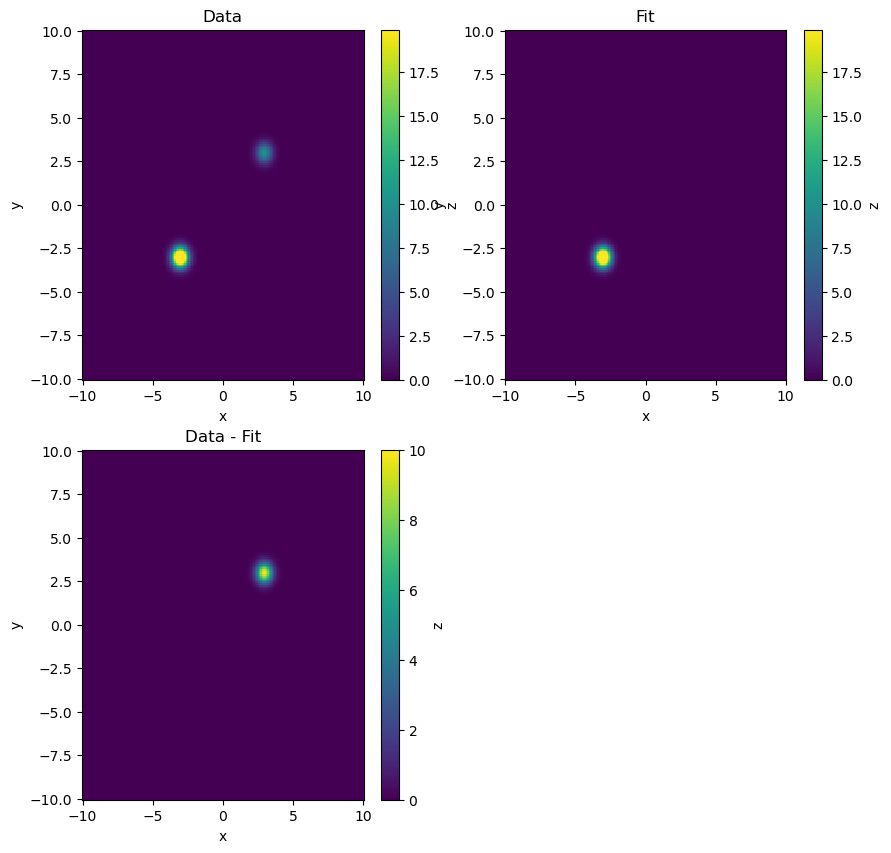

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

vmax = np.nanpercentile(z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(x_grid, y_grid, z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(x_grid, y_grid, **result.best_values)
art = ax.pcolor(x_grid, y_grid, fit, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

residual = z-fit
ax = axs[1, 0]
fit = model.func(x_grid, y_grid, **result.best_values)
art = ax.pcolor(x_grid, y_grid, residual, vmin=0, vmax=10, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
axs[1, 1].remove()
plt.show()

In [53]:
z = residual
i,j = np.unravel_index(z.argmax(), z.shape)

model = lmfit.Model(gaussian2d, independent_vars=['x', 'y'])
params = model.make_params(amplitude=30, centerx=x[i],
                           centery=y[j],sigmax = 0.3,sigmay = 0.3)

result = model.fit(z, x=x_grid, y=y_grid, params=params, weights=1/error)
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 40000
    # variables        = 5
    chi-square         = 2.4424e-20
    reduced chi-square = 6.1067e-25
    Akaike info crit   = -2230204.60
    Bayesian info crit = -2230161.62
    R-squared          = 1.00000000
[[Variables]]
    amplitude:  10.0530965 +/- 3.0148e-13 (0.00%) (init = 30)
    centerx:    3.00000000 +/- 1.3008e-14 (0.00%) (init = 2.964824)
    centery:    3.00000000 +/- 1.3008e-14 (0.00%) (init = 2.964824)
    sigmax:     0.40000000 +/- 1.1223e-14 (0.00%) (init = 0.3)
    sigmay:     0.40000000 +/- 1.1223e-14 (0.00%) (init = 0.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) = 0.231
    C(amplitude, sigmax) = 0.231


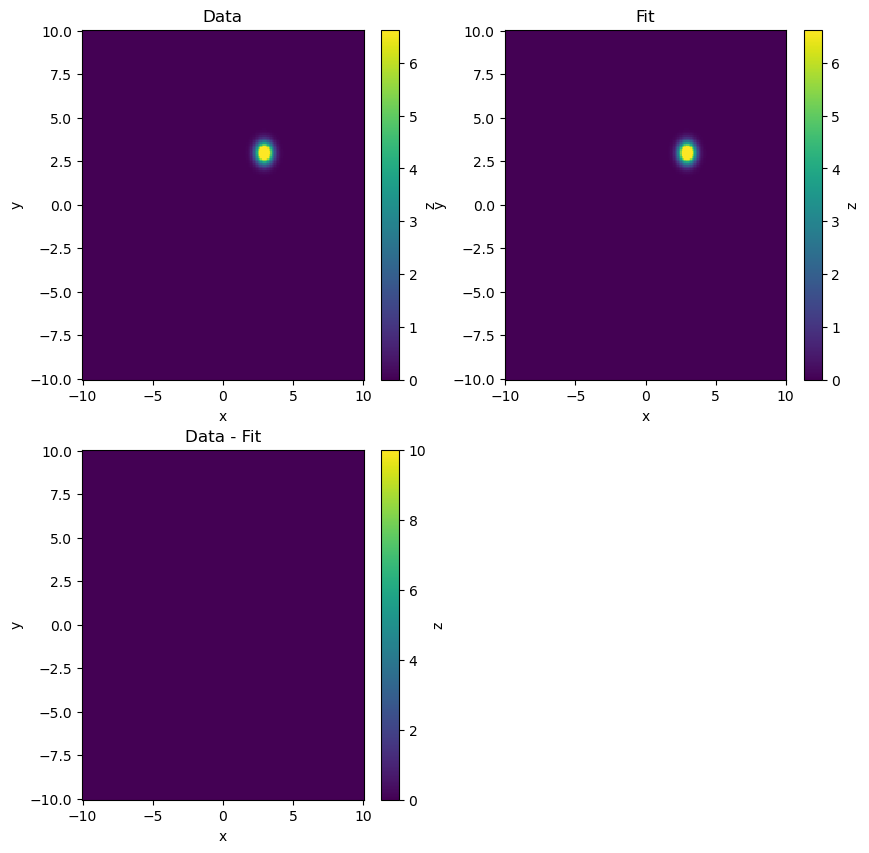

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

vmax = np.nanpercentile(z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(x_grid, y_grid, z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(x_grid, y_grid, **result.best_values)
art = ax.pcolor(x_grid, y_grid, fit, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

residual = z-fit
ax = axs[1, 0]
fit = model.func(x_grid, y_grid, **result.best_values)
art = ax.pcolor(x_grid, y_grid, residual, vmin=0, vmax=10, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
axs[1, 1].remove()
plt.show()

(200, 200)


C:\Users\DELL\AppData\Local\Temp\ipykernel_14872\488166892.py:19: RuntimeWarning: invalid value encountered in sqrt
  error = np.sqrt(z + 1)


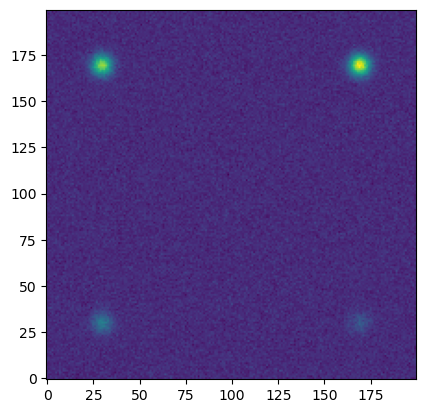

In [55]:
def gauss2d(x,y,amp,centerx,centery,sigmax,sigmay):
    return (amp/(2. * np.pi * sigmax * sigmay))*np.exp(-((x - centerx)**2. / (2. * sigmax**2.) + (y - centery)**2. / (2.*sigmay**2.)))

x = np.linspace(0,20,200)
y = np.linspace(0,20,200)

y_grid,x_grid = np.meshgrid(x,y,sparse=False, indexing='ij')
print(y_grid.shape)


z = gauss2d(x_grid,y_grid,30,17,17,0.4,0.4)
z += gauss2d(x_grid,y_grid,10,3,3,0.4,0.4)
z += gauss2d(x_grid,y_grid,25,3,17,0.4,0.4)
z += gauss2d(x_grid,y_grid,5,17,3,0.4,0.4)
noise = np.random.normal(0,1,z.shape)
thresh = np.nanmax(noise)
z+= noise

error = np.sqrt(z + 1)
plt.figure()
plt.imshow(z,origin = 'lower')
plt.show()

1
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 40000
    # variables        = 5
    chi-square         = 76826.5347
    reduced chi-square = 1.92090348
    Akaike info crit   = 26116.8252
    Bayesian info crit = 26159.8084
    R-squared          = 0.35946093
[[Variables]]
    amplitude:  29.9206617 +/- 0.27860822 (0.93%) (init = 30.7803)
    centerx:    16.9980008 +/- 0.00369626 (0.02%) (init = 16.98492)
    centery:    16.9967555 +/- 0.00373431 (0.02%) (init = 16.98492)
    sigmax:     0.39697431 +/- 0.00369626 (0.93%) (init = 0.1)
    sigmay:     0.40102790 +/- 0.00373431 (0.93%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmax) = 0.500
    C(amplitude, sigmay) = 0.500


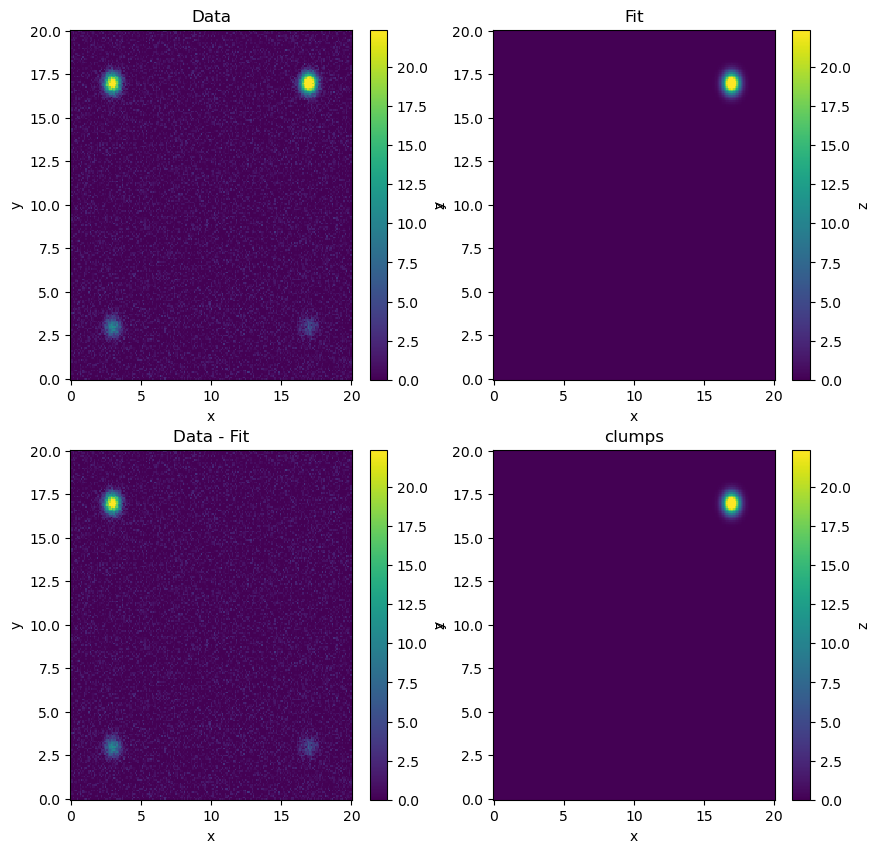

C:\Users\DELL\AppData\Local\Temp\ipykernel_14872\1578973007.py:50: RuntimeWarning: invalid value encountered in sqrt
  error = np.sqrt(z + 1)


2
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 40000
    # variables        = 5
    chi-square         = 46089.5970
    reduced chi-square = 1.15238397
    Akaike info crit   = 5678.31234
    Bayesian info crit = 5721.29552
    R-squared          = 0.39704113
[[Variables]]
    amplitude:  24.9445898 +/- 0.21600260 (0.87%) (init = 25.6291)
    centerx:    2.99578448 +/- 0.00343523 (0.11%) (init = 3.115578)
    centery:    16.9979800 +/- 0.00348127 (0.02%) (init = 16.98492)
    sigmax:     0.39670969 +/- 0.00343523 (0.87%) (init = 0.1)
    sigmay:     0.40202738 +/- 0.00348127 (0.87%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmay) = 0.500
    C(amplitude, sigmax) = 0.500


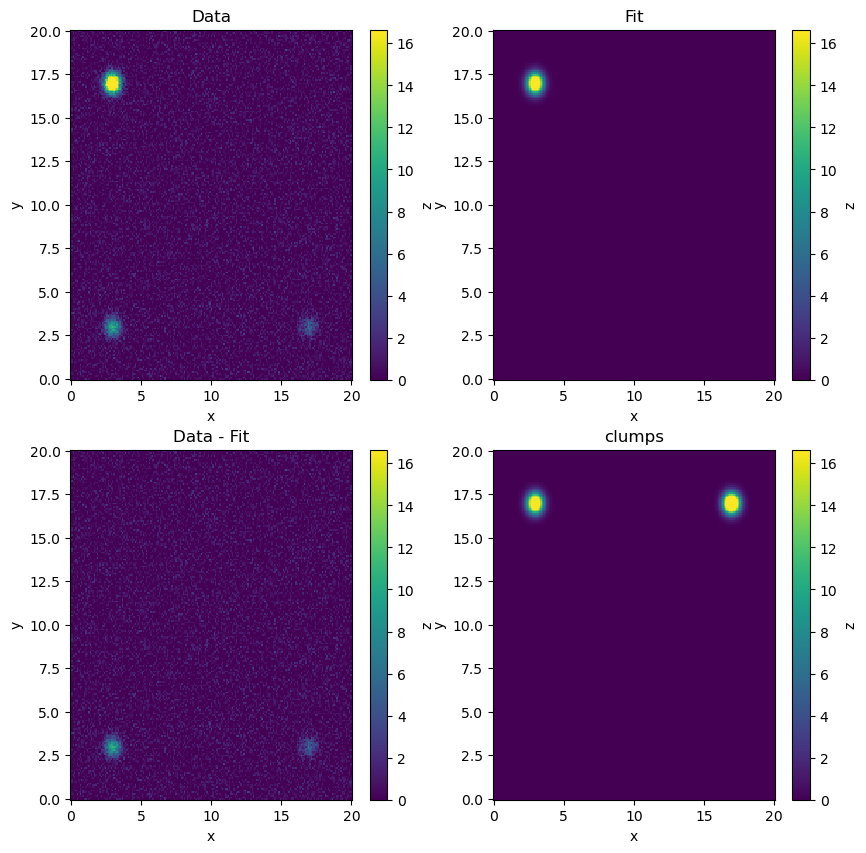

3
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 40000
    # variables        = 5
    chi-square         = 41102.4432
    reduced chi-square = 1.02768954
    Akaike info crit   = 1097.52448
    Bayesian info crit = 1140.50765
    R-squared          = 0.10716281
[[Variables]]
    amplitude:  10.1697848 +/- 0.20644435 (2.03%) (init = 11.37444)
    centerx:    3.01249035 +/- 0.00815282 (0.27%) (init = 3.015075)
    centery:    2.99411263 +/- 0.00825801 (0.28%) (init = 3.015075)
    sigmax:     0.40163290 +/- 0.00815282 (2.03%) (init = 0.1)
    sigmay:     0.40679704 +/- 0.00825801 (2.03%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmax) = 0.500
    C(amplitude, sigmay) = 0.500


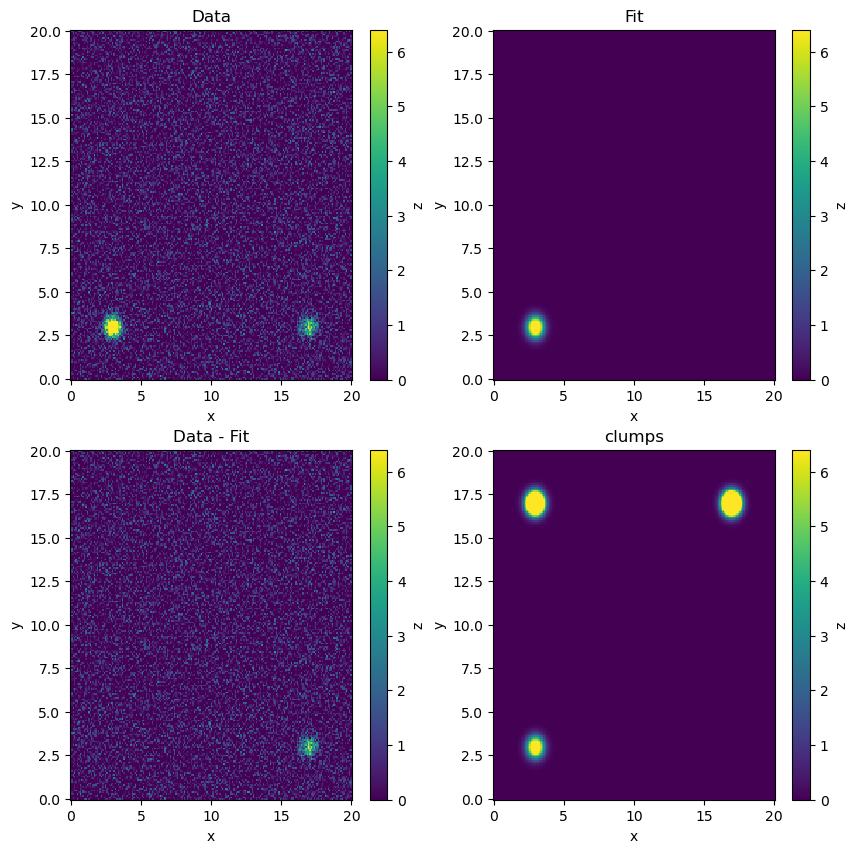

4
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 40000
    # variables        = 5
    chi-square         = 39844.3823
    reduced chi-square = 0.99623409
    Akaike info crit   = -145.921165
    Bayesian info crit = -102.937991
    R-squared          = 0.03048285
[[Variables]]
    amplitude:  5.28311560 +/- 0.21030449 (3.98%) (init = 6.849197)
    centerx:    17.0123128 +/- 0.01703768 (0.10%) (init = 16.98492)
    centery:    3.01741965 +/- 0.01625921 (0.54%) (init = 2.914573)
    sigmax:     0.42788946 +/- 0.01703768 (3.98%) (init = 0.1)
    sigmay:     0.40849186 +/- 0.01625921 (3.98%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigmax) = 0.500
    C(amplitude, sigmay) = 0.500


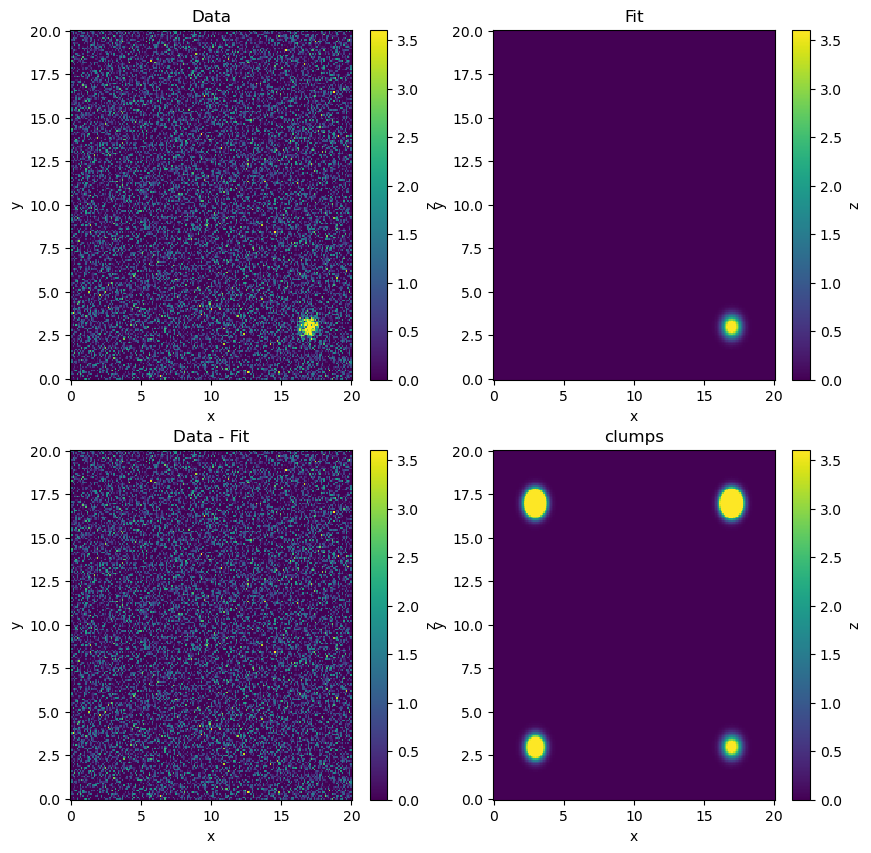

In [56]:
clumps = np.zeros_like(z)
max_iteration = 10
iter_step = 0

while np.nanmax(z)>thresh:
    iter_step += 1
    print(iter_step)

    j,i = np.unravel_index(z.argmax(), z.shape)
    model = lmfit.Model(gaussian2d, independent_vars=['x', 'y'])
    params = model.make_params(amplitude=np.nanmax(z), centerx=x[i],
                            centery=y[j],sigmax = 0.1,sigmay = 0.1)

    result = model.fit(z, x=x_grid, y=y_grid, params=params)
    lmfit.report_fit(result)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    vmax = np.nanpercentile(z, 99.9)

    ax = axs[0, 0]
    art = ax.pcolor(x_grid, y_grid, z, vmin=0, vmax=vmax, shading='auto')
    plt.colorbar(art, ax=ax, label='z')
    ax.set_title('Data')

    ax = axs[0, 1]
    fit = model.func(x_grid, y_grid, **result.best_values)
    art = ax.pcolor(x_grid, y_grid, fit, vmin=0, vmax=vmax, shading='auto')
    plt.colorbar(art, ax=ax, label='z')
    ax.set_title('Fit')

    residual = z-fit
    clumps += fit

    ax = axs[1, 0]
    art = ax.pcolor(x_grid, y_grid, residual, vmin=0, vmax=vmax, shading='auto')
    plt.colorbar(art, ax=ax, label='z')
    ax.set_title('Data - Fit')

    ax = axs[1, 1]
    art = ax.pcolor(x_grid, y_grid, clumps, vmin=0, vmax=vmax, shading='auto')
    plt.colorbar(art, ax=ax, label='z')
    ax.set_title('clumps')

    for ax in axs.ravel():
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    plt.show()

    z = residual
    error = np.sqrt(z + 1)

    if iter_step >= max_iteration:
        break



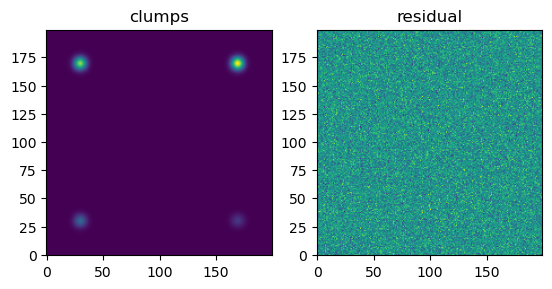

In [57]:
plt.figure()
ax1 = plt.subplot(122)
ax1.imshow(z,origin='lower')
ax1.set_title('residual')
ax2 = plt.subplot(121)
ax2.imshow(clumps,origin='lower')
ax2.set_title('clumps')
plt.show()